In [1]:
from dotenv import load_dotenv
load_dotenv()  # carica le variabili d'ambiente dal file .env

True

In [2]:
from langchain.agents import create_agent
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

In [3]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

loader = PyPDFLoader("../data/resources/acmecorp-employee-handbook.pdf")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

vectorstore = FAISS.from_documents(
    texts, 
    embeddings,
    distance_strategy="COSINE")

retrivier = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}
)

incorrect startxref pointer(1)
parsing for Object Streams


# 🧠 Approfondimento: Embedding e Similiarità Semantica

## Cosa sono gli Embedding?

Gli **embedding** sono rappresentazioni numeriche (vettori) di testo. Convertono il significato semantico di una parola, frase o documento in un array di numeri reali. 

**Proprietà fondamentali:**
- **Rappresentazione continua**: Ogni testo diventa un vettore di dimensioni fisse (es. 384 dimensioni per `all-MiniLM-L6-v2`)
- **Significato semantico preservato**: Testi simili hanno embedding simili nello spazio vettoriale
- **Riduzione di dimensionalità**: Le informazioni testuali complesse vengono compresse in poche centinaia di numeri

**Analogia**: Se immagini uno spazio 3D, ogni concetto/parola/frase è un punto. Due punti vicini rappresentano concetti simili.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean, minkowski
import pandas as pd

# Usiamo lo stesso modello di embedding già configurato
print(f"Modello di embedding: sentence-transformers/all-MiniLM-L6-v2")
print(f"Dimensione dell'embedding: 384 dimensioni")


Modello di embedding: sentence-transformers/all-MiniLM-L6-v2
Dimensione dell'embedding: 384 dimensioni


## Esempio 1: Trasformare una Frase in un Vettore

Vediamo come il modello HuggingFace converte una semplice frase in 384 numeri:


In [5]:
# Creiamo alcuni testi esempio
frasi_esempio = [
    "Il gatto è un animale domestico",
    "Il cane è un animale domestico",
    "L'informatica è la scienza dei computer",
    "Python è un linguaggio di programmazione",
    "Mi piace giocare a calcio al parco"
]

# Otteniamo gli embedding per ogni frase
embedding_vettori = embeddings.embed_documents(frasi_esempio)

print(f"Numero di frasi: {len(frasi_esempio)}")
print(f"Dimensione di ogni embedding: {len(embedding_vettori[0])} numeri")
print(f"\nEmbedding della prima frase ('{frasi_esempio[0]}'):")
print(f"Primi 20 valori: {embedding_vettori[0][:20]}")
print(f"...(nascosti i restanti 364 valori)...")
print(f"\nSomma del quadrato dei valori (norma L2): {np.sum(np.array(embedding_vettori[0])**2):.4f}")


Numero di frasi: 5
Dimensione di ogni embedding: 384 numeri

Embedding della prima frase ('Il gatto è un animale domestico'):
Primi 20 valori: [-0.056124601513147354, 0.0904669389128685, -0.003502789419144392, 0.03233598917722702, -0.05948733910918236, -0.011107810772955418, 0.06421226263046265, 0.02945982851088047, -0.0030595234129577875, 0.03620687499642372, 0.0913551077246666, -0.08440619707107544, -0.025270402431488037, 0.011953662149608135, -0.027744190767407417, -0.11311493068933487, 0.022758513689041138, 0.05026761069893837, -0.0019595648627728224, 0.06216192990541458]
...(nascosti i restanti 364 valori)...

Somma del quadrato dei valori (norma L2): 1.0000


## Esempio 2: Confronto Semantico tra Embedding

Adesso confrontiamo i vettori per vedere quali frasi sono semanticamente simili. Usiamo diverse metriche di distanza:


In [6]:
# Convertiamo in numpy arrays per facilità di calcolo
embeddings_array = np.array(embedding_vettori)

# Funzione per calcolare la similarità coseno (1 - distanza coseno)
# La similarità coseno misura l'angolo tra due vettori
def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

# Funzione per calcolare il dot product (prodotto scalare)
def dot_product_similarity(v1, v2):
    return np.dot(v1, v2)

# Creiamo una matrice di similarità coseno
print("=" * 70)
print("MATRICE DI SIMILARITÀ COSENO (Consigliato per embedding semantici)")
print("=" * 70)
print("Valori da 0 (diversi) a 1 (identici)\n")

cosine_sim_matrix = np.zeros((len(frasi_esempio), len(frasi_esempio)))
for i in range(len(frasi_esempio)):
    for j in range(len(frasi_esempio)):
        cosine_sim_matrix[i][j] = cosine_similarity(embeddings_array[i], embeddings_array[j])

# Creiamo un DataFrame per leggere meglio i risultati
df_cosine = pd.DataFrame(
    cosine_sim_matrix,
    index=[f"F{i+1}" for i in range(len(frasi_esempio))],
    columns=[f"F{i+1}" for i in range(len(frasi_esempio))]
)
print(df_cosine.round(4))
print("\nLegenda:")
for i, frase in enumerate(frasi_esempio):
    print(f"F{i+1}: {frase}")

# Analizziamo le coppie più simili
print("\n" + "=" * 70)
print("TOP 5 COPPIE PIÙ SIMILI (escluse le uguali)")
print("=" * 70)
similarities = []
for i in range(len(frasi_esempio)):
    for j in range(i+1, len(frasi_esempio)):
        similarities.append({
            'Frase 1': frasi_esempio[i],
            'Frase 2': frasi_esempio[j],
            'Similarità Coseno': cosine_sim_matrix[i][j]
        })

df_sim = pd.DataFrame(similarities).sort_values('Similarità Coseno', ascending=False)
for idx, row in df_sim.head(5).iterrows():
    print(f"\n{row['Similarità Coseno']:.4f} - Frase 1: {row['Frase 1']}")
    print(f"         Frase 2: {row['Frase 2']}")


MATRICE DI SIMILARITÀ COSENO (Consigliato per embedding semantici)
Valori da 0 (diversi) a 1 (identici)

        F1      F2      F3      F4      F5
F1  1.0000  0.8247  0.3413  0.3146  0.4889
F2  0.8247  1.0000  0.3322  0.3049  0.4780
F3  0.3413  0.3322  1.0000  0.4589  0.4225
F4  0.3146  0.3049  0.4589  1.0000  0.4150
F5  0.4889  0.4780  0.4225  0.4150  1.0000

Legenda:
F1: Il gatto è un animale domestico
F2: Il cane è un animale domestico
F3: L'informatica è la scienza dei computer
F4: Python è un linguaggio di programmazione
F5: Mi piace giocare a calcio al parco

TOP 5 COPPIE PIÙ SIMILI (escluse le uguali)

0.8247 - Frase 1: Il gatto è un animale domestico
         Frase 2: Il cane è un animale domestico

0.4889 - Frase 1: Il gatto è un animale domestico
         Frase 2: Mi piace giocare a calcio al parco

0.4780 - Frase 1: Il cane è un animale domestico
         Frase 2: Mi piace giocare a calcio al parco

0.4589 - Frase 1: L'informatica è la scienza dei computer
         Frase 2:

## Esempio 3: Confronto tra Diversi Tipi di Distanza/Similarità

Vediamo come cambia il ranking a seconda della metrica utilizzata:


In [7]:
# Calcoliamo diverse metriche di distanza per le coppie (Frase 0 vs tutte le altre)
query_idx = 0
query_frase = frasi_esempio[query_idx]
query_embedding = embeddings_array[query_idx]

print(f"Query Frase: '{query_frase}'\n")
print("=" * 100)
print(f"{'Confronto con':<50} {'Coseno':<15} {'Euclidea':<15} {'Manhattan':<15}")
print("=" * 100)

metriche = []
for i, frase in enumerate(frasi_esempio):
    if i == query_idx:
        continue
    
    embedding = embeddings_array[i]
    
    # 1. SIMILARITÀ COSENO (1 - cosine distance)
    cos_sim = cosine_similarity(query_embedding, embedding)
    
    # 2. DISTANZA EUCLIDEA (radice della somma dei quadrati delle differenze)
    eucl_dist = euclidean(query_embedding, embedding)
    
    # 3. DISTANZA MANHATTAN (somma dei valori assoluti delle differenze, minkowski con p=1)
    manh_dist = minkowski(query_embedding, embedding, p=1)
    
    # 4. DOT PRODUCT (senza normalizzazione)
    dot_sim = dot_product_similarity(query_embedding, embedding)
    
    metriche.append({
        'Frase': frase,
        'Coseno': cos_sim,
        'Euclidea': eucl_dist,
        'Manhattan': manh_dist,
        'Dot Product': dot_sim
    })
    
    print(f"{frase:<50} {cos_sim:<15.4f} {eucl_dist:<15.4f} {manh_dist:<15.2f}")

print("\n" + "=" * 100)
print("SPIEGAZIONE DELLE METRICHE:")
print("=" * 100)

spiegazioni = """
1. SIMILARITÀ COSENO (0-1, maggiore = più simile)
   - Misura l'angolo tra due vettori
   - INDIPENDENTE dalla magnitudine dei vettori
   - Ideale per: embedding semantici, ricerca di documenti, similarità di testo
   - Pro: Stabile anche con embedding normalizzati
   - Contro: Non considera la "forza" del significato (magnitudine)

2. DISTANZA EUCLIDEA (0+, minore = più simile)
   - Misura la distanza geometrica in spazio euclideo
   - DIPENDE dalla magnitudine dei vettori
   - Ideale per: clustering K-means, ricerca di vicinanza spaziale
   - Pro: Intuitiva geometricamente
   - Contro: Sensibile alla scala e alla magnitudine

3. DISTANZA MANHATTAN (0+, minore = più simile)
   - Somma dei valori assoluti delle differenze (distanza "a griglia")
   - DIPENDE dalla magnitudine
   - Ideale per: dati sparsi, grafi, ottimizzazione con L1 regularization
   - Pro: Computazionalmente veloce
   - Contro: Meno naturale per testi ad alta dimensionalità

4. DOT PRODUCT / PRODOTTO SCALARE (valori variabili)
   - Moltiplicazione elemento per elemento e somma
   - DIPENDE MOLTO dalla magnitudine
   - Ideale per: quando la magnitudine ha significato, scoring personalizzato
   - Pro: Veloce, utile quando magnitudine importa
   - Contro: Non normalizzato, difficile interpretare i valori
"""

print(spiegazioni)


Query Frase: 'Il gatto è un animale domestico'

Confronto con                                      Coseno          Euclidea        Manhattan      
Il cane è un animale domestico                     0.8247          0.5921          9.57           
L'informatica è la scienza dei computer            0.3413          1.1478          17.42          
Python è un linguaggio di programmazione           0.3146          1.1708          18.08          
Mi piace giocare a calcio al parco                 0.4889          1.0110          15.62          

SPIEGAZIONE DELLE METRICHE:

1. SIMILARITÀ COSENO (0-1, maggiore = più simile)
   - Misura l'angolo tra due vettori
   - INDIPENDENTE dalla magnitudine dei vettori
   - Ideale per: embedding semantici, ricerca di documenti, similarità di testo
   - Pro: Stabile anche con embedding normalizzati
   - Contro: Non considera la "forza" del significato (magnitudine)

2. DISTANZA EUCLIDEA (0+, minore = più simile)
   - Misura la distanza geometrica in spazio 

## Esempio 4: Visualizzazione dei Vettori (Riduzione a 2D)

Riduciamo gli embedding da 384 dimensioni a 2 dimensioni per visualizzarli graficamente:


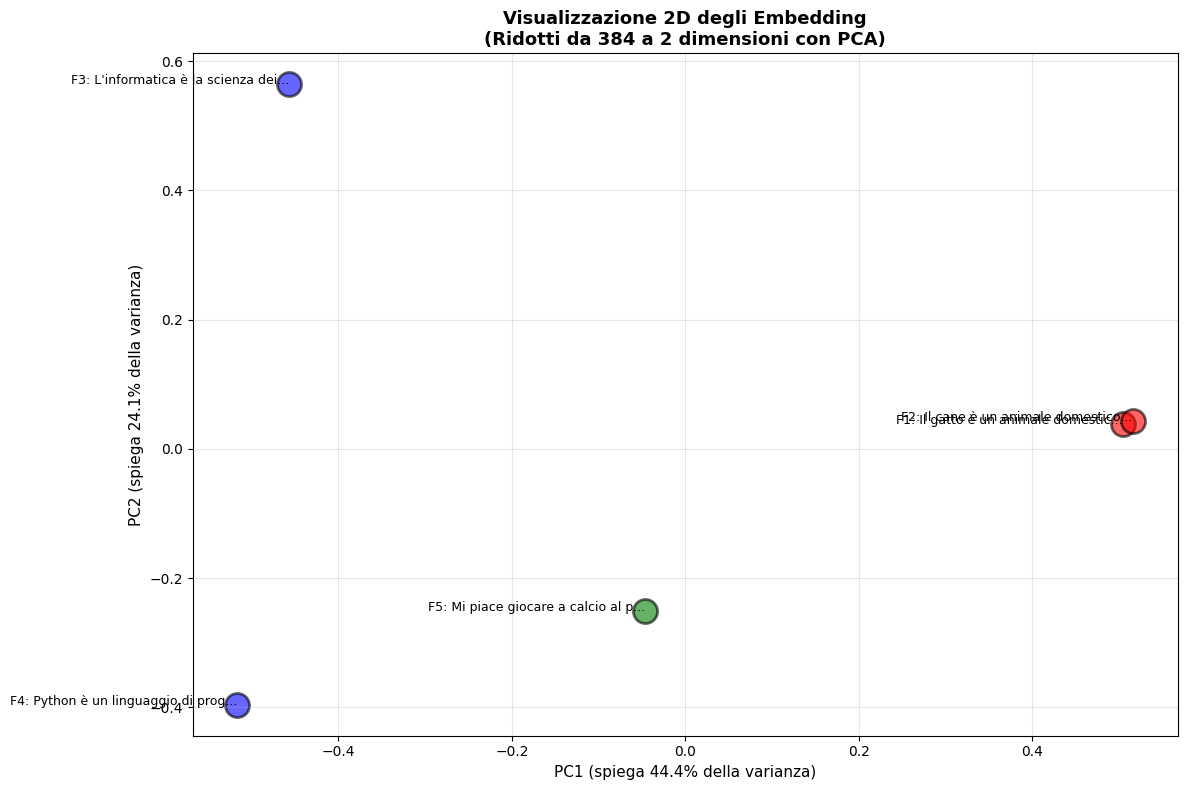

Varianza spiegata: PC1=44.4%, PC2=24.1%
Totale: 68.5%

✓ Nota: Frasi simili (stesso colore) sono vicine nello spazio 2D!
  In realtà, le similarità reali si vedono meglio negli spazi a 384 dimensioni!


In [8]:
# Usiamo PCA per ridurre da 384 a 2 dimensioni
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Creiamo il grafico
plt.figure(figsize=(12, 8))

# Colori diversi per ogni categoria semantica
colori = ['red', 'red', 'blue', 'blue', 'green']
labels = ['Animali Domestici 1', 'Animali Domestici 2', 'Informatica 1', 'Informatica 2', 'Sport']

for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, s=300, c=colori[i], alpha=0.6, edgecolors='black', linewidth=2)
    # Abbrevia il testo per leggibilità
    testo_breve = frasi_esempio[i][:30] + "..."
    plt.annotate(f"F{i+1}: {testo_breve}", (x, y), fontsize=9, ha='right')

plt.xlabel(f'PC1 (spiega {pca.explained_variance_ratio_[0]*100:.1f}% della varianza)', fontsize=11)
plt.ylabel(f'PC2 (spiega {pca.explained_variance_ratio_[1]*100:.1f}% della varianza)', fontsize=11)
plt.title('Visualizzazione 2D degli Embedding\n(Ridotti da 384 a 2 dimensioni con PCA)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Varianza spiegata: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"Totale: {sum(pca.explained_variance_ratio_)*100:.1f}%")
print("\n✓ Nota: Frasi simili (stesso colore) sono vicine nello spazio 2D!")
print("  In realtà, le similarità reali si vedono meglio negli spazi a 384 dimensioni!")


## Esempio 5: Applicazione a RAG - Come Funziona la Ricerca Semantica

Nel nostro sistema RAG (Retrieval-Augmented Generation), ecco cosa succede quando cerchiamo un documento:


In [9]:
# Simuliamo una query RAG
query_text = "Quanto tempo posso assentarmi dal lavoro?"

print("=" * 80)
print("COME FUNZIONA LA RICERCA SEMANTICA IN RAG")
print("=" * 80)

print(f"\n1️⃣ Query ricevuta dall'utente:")
print(f"   '{query_text}'")

# Passo 1: Trasformare la query in embedding
query_embedding_vec = embeddings.embed_query(query_text)

print(f"\n2️⃣ Trasformazione in embedding:")
print(f"   Embedding generato con {len(query_embedding_vec)} numeri")
print(f"   Primi 10 valori: {query_embedding_vec[:10]}")

# Passo 2: Calcolare la similarità con tutti i documenti nel vectorstore
print(f"\n3️⃣ Calcolo della similarità coseno con tutti i {vectorstore.index.ntotal} documenti nel FAISS index:")

# Fatto automaticamente da FAISS durante similarity_search
results = vectorstore.similarity_search(query_text, k=3)

# Calcoliamo i scores manualmente
query_emb = np.array(embeddings.embed_query(query_text))

print(f"\n4️⃣ Risultati della ricerca (Top 3):\n")
for i, doc in enumerate(results, 1):
    # Calcoliamo il cosine similarity manualmente
    doc_emb = np.array(embeddings.embed_query(doc.page_content))
    score = np.dot(query_emb, doc_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(doc_emb))
    print(f"   Documento #{i} (Similarità: {score:.4f})")
    print(f"   Contenuto: {doc.page_content[:120]}...")
    print()

print("=" * 80)
print("🎯 PROCESSO DI RAG RIASSUNTO:")
print("=" * 80)
print("""
1. Query dell'utente → Embedding (trasformazione semantica)
2. Embedding della query → Ricerca nel vectorstore con FAISS
3. FAISS calcola la similarità coseno con tutti i documenti
4. Restituisce i K documenti più simili
5. I documenti trovati vengono passati al modello LLM
6. L'LLM genera una risposta basata su questi documenti
""")


COME FUNZIONA LA RICERCA SEMANTICA IN RAG

1️⃣ Query ricevuta dall'utente:
   'Quanto tempo posso assentarmi dal lavoro?'

2️⃣ Trasformazione in embedding:
   Embedding generato con 384 numeri
   Primi 10 valori: [-0.038274504244327545, 0.06983256340026855, -0.031199174001812935, -0.03197711333632469, -0.14593181014060974, 0.04021988436579704, 0.0924888551235199, 0.0020475161727517843, 0.12238547205924988, 0.01398364920169115]

3️⃣ Calcolo della similarità coseno con tutti i 5 documenti nel FAISS index:

4️⃣ Risultati della ricerca (Top 3):

   Documento #1 (Similarità: 0.1761)
   Contenuto: Paid Time Off (PTO) Policy
Full■time employees accrue PTO according to the following schedule:  0–1 years of service: 1...

   Documento #2 (Similarità: 0.1634)
   Contenuto: an emergency. Employees may carry over up to 5 unused PTO days per calendar year. Extended
absences exceeding 5 consecut...

   Documento #3 (Similarità: 0.1578)
   Contenuto: after employment ends.
Workplace Conduct Policy
E

## Tabella Comparativa: Quando Usare Quale Metrica?

Ecco una guida pratica per scegliere la metrica giusta:


In [10]:
# Creiamo una tabella comparativa
import pandas as pd

tabella_metriche = pd.DataFrame({
    'Metrica': [
        'Coseno Similarity',
        'Euclidea Distance',
        'Manhattan Distance',
        'Dot Product',
        'Hamming Distance'
    ],
    'Range': [
        '0 a 1 (sim)',
        '0+ (dist)',
        '0+ (dist)',
        'Variabile',
        '0+ (dist)'
    ],
    'Dipende Magnitudine': [
        'No ✓',
        'Sì ✗',
        'Sì ✗',
        'Sì ✗',
        'No ✓'
    ],
    'Velocità': [
        'Veloce',
        'Media',
        'Veloce ⚡',
        'Veloce ⚡',
        'Veloce ⚡'
    ],
    'Caso d\'uso Principale': [
        'RAG, NLP, Similiarità testo',
        'Clustering (K-means)',
        'Dati sparsi, grafi',
        'Scoring personalizzato',
        'Testo binario, booleano'
    ],
    'Vantaggi': [
        'Naturale, robusta, normalizzata',
        'Intuitiva geometricamente',
        'Computazionalmente efficiente',
        'Veloce, sensibile alla scala',
        'Perfetta per dati binari'
    ]
})

print(tabella_metriche.to_string(index=False))

print("\n" + "=" * 100)
print("🏆 CONSIGLIO PER RAG CON HUGGINGFACE EMBEDDINGS:")
print("=" * 100)
print("""
✅ USA: Cosine Similarity
   - I modelli HuggingFace producono embedding normalizzati
   - La similarità coseno è invariante alla scala
   - È lo standard dell'industria per RAG
   - FAISS la usa di default (similarity_search)
   
Esempio FAISS:
    results = vectorstore.similarity_search(query, k=5)  # Usa coseno internamente
    results_with_scores = vectorstore.similarity_search_with_scores(query, k=5)
""")


           Metrica       Range Dipende Magnitudine Velocità       Caso d'uso Principale                        Vantaggi
 Coseno Similarity 0 a 1 (sim)                No ✓   Veloce RAG, NLP, Similiarità testo Naturale, robusta, normalizzata
 Euclidea Distance   0+ (dist)                Sì ✗    Media        Clustering (K-means)       Intuitiva geometricamente
Manhattan Distance   0+ (dist)                Sì ✗ Veloce ⚡          Dati sparsi, grafi   Computazionalmente efficiente
       Dot Product   Variabile                Sì ✗ Veloce ⚡      Scoring personalizzato    Veloce, sensibile alla scala
  Hamming Distance   0+ (dist)                No ✓ Veloce ⚡     Testo binario, booleano        Perfetta per dati binari

🏆 CONSIGLIO PER RAG CON HUGGINGFACE EMBEDDINGS:

✅ USA: Cosine Similarity
   - I modelli HuggingFace producono embedding normalizzati
   - La similarità coseno è invariante alla scala
   - È lo standard dell'industria per RAG
   - FAISS la usa di default (similarity_search)

Ese

## Esempio 6: Variare il Numero di Risultati (k) e Impatto sulla Qualità

Vediamo come cambia la qualità dei risultati variando il numero di documenti recuperati:


In [11]:
# Stessa query con diversi valori di k
test_query = "Qual è la politica di ferie dell'azienda?"

print("=" * 100)
print(f"Query: '{test_query}'")
print("=" * 100)

for k in [1, 2, 5]:
    print(f"\n📊 RISULTATI CON k={k}:")
    print("-" * 100)
    
    docs = vectorstore.similarity_search(test_query, k=k)
    query_emb_test = np.array(embeddings.embed_query(test_query))
    
    for i, doc in enumerate(docs, 1):
        # Calcoliamo il cosine similarity manualmente
        doc_emb_test = np.array(embeddings.embed_query(doc.page_content))
        score = np.dot(query_emb_test, doc_emb_test) / (np.linalg.norm(query_emb_test) * np.linalg.norm(doc_emb_test))
        print(f"\n{i}. Similarità: {score:.4f}")
        print(f"   Pagina: {doc.metadata.get('page', 'N/A')}")
        print(f"   Anteprima: {doc.page_content[:100]}...")

print("\n" + "=" * 100)
print("💡 CONSIDERAZIONI PER LA SCELTA DI k:")
print("=" * 100)
print("""
k = 1: Più veloce, minore contesto
   ✅ Quando: Risposte semplici e dirette
   ❌ Quando: Risposte che necessitano di molteplici fonti

k = 2-3: Equilibrato (DEFAULT in molti RAG)
   ✅ Quando: La maggior parte dei casi pratici
   ❌ Quando: Domande molto complesse

k = 5+: Più contesto, può aggiungere rumore
   ✅ Quando: Domande complesse, controversiali, multi-aspetto
   ❌ Quando: Risorse limitate, LLM con finestra limitata
   
⚠️ Attenzione: Se k è troppo grande, potresti includere documenti non rilevanti
            che confondono il modello generativo
""")


Query: 'Qual è la politica di ferie dell'azienda?'

📊 RISULTATI CON k=1:
----------------------------------------------------------------------------------------------------

1. Similarità: 0.0232
   Pagina: 0
   Anteprima: Paid Time Off (PTO) Policy
Full■time employees accrue PTO according to the following schedule:  0–1...

📊 RISULTATI CON k=2:
----------------------------------------------------------------------------------------------------

1. Similarità: 0.0232
   Pagina: 0
   Anteprima: Paid Time Off (PTO) Policy
Full■time employees accrue PTO according to the following schedule:  0–1...

2. Similarità: 0.0141
   Pagina: 0
   Anteprima: after employment ends.
Workplace Conduct Policy
Employees must maintain a respectful, professional e...

📊 RISULTATI CON k=5:
----------------------------------------------------------------------------------------------------

1. Similarità: 0.0232
   Pagina: 0
   Anteprima: Paid Time Off (PTO) Policy
Full■time employees accrue PTO according 

## Riepilogo: Cosa Abbiamo Imparato

### 🎓 Concetti Chiave su Embedding e RAG:

1. **Embedding**: Rappresentazione numerica (vettore) del significato semantico di un testo
   - Trasformano il testo in array di numeri reali (es. 384 numeri)
   - Preservano il significato semantico: testi simili → embedding simili

2. **Metriche di Similarità**:
   - **Coseno**: La scelta migliore per testi/NLP ✓
   - **Euclidea**: Per clustering spaziale
   - **Manhattan**: Per dati sparsi
   - **Dot Product**: Per scoring personalizzato

3. **Come funziona RAG**:
   - Utente pone una domanda
   - La domanda viene trasformata in embedding
   - Si calcola la similarità coseno con tutti i documenti
   - Vengono recuperati i k documenti più simili
   - L'LLM genera una risposta usando questi documenti

4. **Parametri importanti**:
   - **k** (numero di risultati): 2-3 è spesso ottimale
   - **Model di embedding**: Il modello HuggingFace usato è cruciale per la qualità
   - **Metrica**: Coseno per RAG, sempre

5. **Vantaggi di RAG**:
   - ✅ Risponde basato su documenti specifici
   - ✅ Riduce allucinazioni dell'LLM
   - ✅ Permette di usare documenti privati
   - ✅ Aggiornabile senza ritrainare il modello
